In [ ]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data import Dataset, SubsetRandomSampler

from torchvision import transforms, models

import matplotlib.pyplot as plt
%matplotlib inline
import os
from google.colab import files

device = torch.device("cuda:0")

In [ ]:
class DigitsDataset(Dataset):
    def __init__ (self, folder_path, csv_file, transform=None):
        self.path = os.path.join(folder_path, csv_file)
        self.file = pd.read_csv(self.path)
        self.transform = transform

    def __len__(self):
        return len(self.file)

    def __getitem__(self, idx):
        #if torch.is_tensor(idx):
            #idx = idx.tolist()
        
        if 'label' in self.file.columns:
            y = self.file.iloc[idx, 0]
            x = self.file.iloc[idx, 1:]
            x = np.array([x])
            x = x.astype('float32').reshape(28, 28)
            if self.transform:
                x = self.transform(x)
            return x, y
        
        x = self.file.iloc[idx, :]
        x = np.array([x])
        x = x.astype('float32').reshape(28, 28)
        if self.transform:
            x = self.transform(x)
        return x

def visualize_samples(dataset, indices, title=None, count=10):
    plt.figure(figsize=(count*3,3))
    indices_to_display = indices[:count]
    if title:
        plt.suptitle("%s %s/%s" % (title, len(indices_to_display), len(indices)))
    for i, index in enumerate(indices_to_display):
        x, y = dataset[index]
        plt.subplot(1, count, i+1)
        plt.title("Label: %s" % y.item())
        plt.imshow(x.cpu().numpy().squeeze())
        plt.grid(False)
        plt.axis('off')

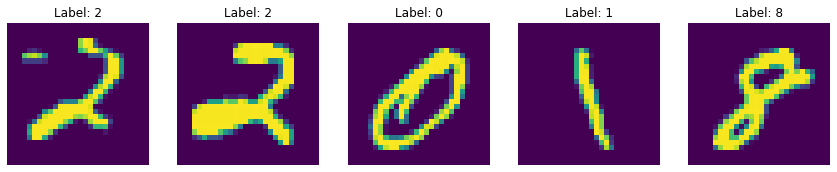

In [ ]:
folder = '/content/drive/My Drive/digits'
data_train = DigitsDataset(folder, 'train.csv', transform=transforms.Compose([transforms.ToTensor()]))

indices = np.random.choice(np.arange(len(data_train)), 5, replace=False)
visualize_samples(data_train, indices)

In [ ]:
batch_size = 16

data_size = len(data_train)
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [ ]:
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, step_size=1, gam=0.99):    
    loss_history = []
    train_history = []
    val_history = []
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gam)

    for epoch in range(num_epochs):
        model.train()
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            x_gpu = x.to(device)
            y_gpu = y.to(device)

            prediction = model(x_gpu)
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value


        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        scheduler.step()
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval()

    correct_samples, total_samples = 0, 0
    for i_step, (x, y) in enumerate(loader):
            x_gpu = x.to(device)
            y_gpu = y.to(device)

            prediction = model(x_gpu) 

            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
    
    return float(correct_samples) / total_samples


In [ ]:
nn_model = nn.Sequential(
            nn.Conv2d(1, 10, 3, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(10, 20, 3, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),    
            Flattener(),
            nn.Linear(360*2, 10),
          )


nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)


loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.Adam(nn_model.parameters(), lr=1e-3, weight_decay=1e-4)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 10, 5, 0.2)

Average loss: 0.275423, Train accuracy: 0.936012, Val accuracy: 0.966310
Average loss: 0.093370, Train accuracy: 0.971190, Val accuracy: 0.974286
Average loss: 0.074485, Train accuracy: 0.976845, Val accuracy: 0.972262
Average loss: 0.063165, Train accuracy: 0.980744, Val accuracy: 0.967262
Average loss: 0.052635, Train accuracy: 0.983810, Val accuracy: 0.977381
Average loss: 0.019138, Train accuracy: 0.993452, Val accuracy: 0.981071
Average loss: 0.010015, Train accuracy: 0.997143, Val accuracy: 0.983571
Average loss: 0.006928, Train accuracy: 0.998185, Val accuracy: 0.982738
Average loss: 0.005332, Train accuracy: 0.998810, Val accuracy: 0.983810
Average loss: 0.004261, Train accuracy: 0.998958, Val accuracy: 0.981310


In [ ]:
example = pd.read_csv('/content/drive/My Drive/digits/sample_submission.csv')
example.head(5)

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [ ]:
test_dataset = DigitsDataset(folder, 'test.csv', transform=transforms.Compose([transforms.ToTensor()]))

In [ ]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)

In [ ]:
def predict(model, loader):
    model.eval()

    predictions = []
    for i, x in enumerate(loader):
        x_gpu = x.to(device)
        pred = model(x_gpu)
        pred = pred.argmax(axis=1).tolist()
        predictions += pred
    return np.array(predictions).flatten()


In [ ]:
nn_model = nn.Sequential(
            nn.Conv2d(1, 10, 3, padding=2),
            nn.BatchNorm2d(10),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(10, 20, 3, padding=0),
            nn.BatchNorm2d(20),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(20, 50, 3, padding=0),
            nn.BatchNorm2d(50),
            nn.ReLU(inplace=True),   
            Flattener(),
            nn.Linear(800, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.Adam(nn_model.parameters(), lr=1e-3, weight_decay=3e-4)

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 30, 5, 0.2)

RuntimeError: ignored

In [ ]:
test_accuracy = compute_accuracy(nn_model, val_loader)
print("Final test accuracy - ", test_accuracy)

Final test accuracy -  0.9930952380952381


In [ ]:
preds = predict(nn_model, test_loader)
name='pos.csv'
pd.DataFrame(preds, index=np.arange(1, 28001), columns=['Label']).to_csv(name, index_label='ImageId')
files.download(name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
old_preds = preds.copy()

In [ ]:
data_train = DigitsDataset(folder, 'train.csv', transform=transforms.Compose([transforms.ToPILImage(),
                                                                              transforms.Resize((224, 224)),
                                                                              transforms.ToTensor(),
                                                                              # Use mean and std for pretrained models
                                                                              # https://pytorch.org/docs/stable/torchvision/models.html
                                                                              transforms.Normalize(mean=[0.485],
                                                                              std=[0.229])]))

data_test =  DigitsDataset(folder, 'test.csv', transform=transforms.Compose([transforms.ToPILImage(),
                                                                              transforms.Resize((224, 224)),
                                                                              transforms.ToTensor(),
                                                                              # Use mean and std for pretrained models
                                                                              # https://pytorch.org/docs/stable/torchvision/models.html
                                                                              transforms.Normalize(mean=[0.485],
                                                                              std=[0.229])]))

In [ ]:
batch_size = 64

data_size = len(data_train)
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)

In [ ]:
model_resnet = models.resnet18(pretrained=False)

num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, 2)

model_resnet = model_resnet.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.Adam(model_resnet.parameters(), lr=1e-3, weight_decay=3e-4)

loss_history, train_history, val_history = train_model(model_resnet, train_loader, val_loader, loss, optimizer, 10, 5, 0.2)

RuntimeError: ignored

Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [ ]:
model_resnet.conv1

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)